In [1]:
from datetime import datetime
import numpy as np
import pickle
import json
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/SPARSe

/content/gdrive/MyDrive/SPARSe


In [4]:
train = pd.read_csv("./features_labels/Features_train3.csv")
train_labels = pd.read_csv("./features_labels/Labels_train3.csv")
test = pd.read_csv("./features_labels/Features_val3.csv")
test_labels = pd.read_csv("./features_labels/Labels_val3.csv")

In [5]:
train = train.merge(train_labels, on="projectid")
train.drop(["Unnamed: 0_y", "Unnamed: 0_x", "projectid"], axis = 1, inplace = True)

In [6]:
train_labels = train["is_fully_funded"].to_numpy()
train_features = train.drop(["is_fully_funded"], axis = 1).to_numpy()

In [7]:
test = test.merge(test_labels, on="projectid")
test.drop(["Unnamed: 0_y", "Unnamed: 0_x", "projectid"], axis = 1, inplace = True)
test_labels = test_labels["is_fully_funded"].to_numpy()
test_features = test.drop(["is_fully_funded"], axis = 1).to_numpy()

In [8]:
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression(solver='lbfgs', max_iter=1000).fit(train_features, train_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
def precision(results, threshold):
  tp = np.sum(results[:int(results.shape[0]*threshold), 2] == 0)
  fp = np.sum(results[:int(results.shape[0]*threshold), 2] == 1)
  if tp+fp == 0:
    return 0.
  return tp/(tp + fp)
def recall(results, threshold):
  tp = np.sum(results[:int(results.shape[0]*threshold), 2] == 0)
  fn = np.sum(results[int(results.shape[0]*threshold):, 2] == 0)
  return tp/(tp + fn)

## Baseline

In [10]:
def poverty_rank(poverty_level, funding_frac_by_evaluation_date):
  if poverty_level == "moderate poverty":
    level = 0
  elif poverty_level == "high poverty":
    level = 1
  elif poverty_level == "low poverty":
    level = 2
  elif poverty_level == "highest poverty":
    level = 3
  return 100.0*level + funding_frac_by_evaluation_date

In [11]:
baseline_results = test[["total_prop_funded", "total_prop_funded", "is_fully_funded"]].to_numpy()
baseline_results = baseline_results[baseline_results[:, 1].argsort()]
baseline_results[:, 1] = np.arange(0, baseline_results.shape[0], 1)/(baseline_results.shape[0]/10.)
import matplotlib.pyplot as plt
n = 10000
x = np.linspace(1/n, 1, n)
baseline_precision_vals = [precision(baseline_results,x_i) for x_i in x]
baseline_recall_vals = [recall(baseline_results,x_i) for x_i in x]

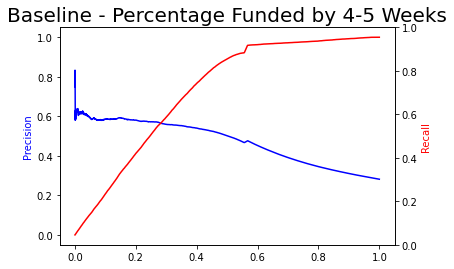

In [46]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, baseline_precision_vals, "-b")
ax1.plot(x, baseline_recall_vals, "-r")
ax1.set_title("Baseline - Percentage Funded by 4-5 Weeks")
ax1.title.set_size(20)
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
plt.show()

## Logistic

In [13]:
logistic_results = np.concatenate([logistic_classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
logistic_results = logistic_results[logistic_results[:, 1].argsort()]

In [14]:
n = 10000
x = np.linspace(1/n, 1, n)
logistic_precision_vals = [precision(logistic_results,x_i) for x_i in x]
logistic_recall_vals = [recall(logistic_results,x_i) for x_i in x]

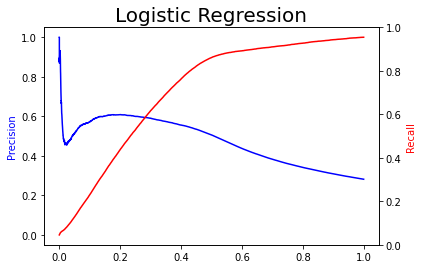

In [45]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, logistic_precision_vals, "-b")
ax1.plot(x, logistic_recall_vals, "-r")
ax1.set_title("Logistic Regression")
ax1.title.set_size(20)
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
plt.show()

## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
decision_classifier = DecisionTreeClassifier(max_depth=5)
decision_classifier = decision_classifier.fit(train_features, train_labels)

In [17]:
decision_results = np.concatenate([decision_classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
decision_results = decision_results[decision_results[:, 1].argsort()]

In [18]:
n = 10000
x = np.linspace(1/n, 1, n)
decision_precision_vals = [precision(decision_results,x_i) for x_i in x]
decision_recall_vals = [recall(decision_results,x_i) for x_i in x]

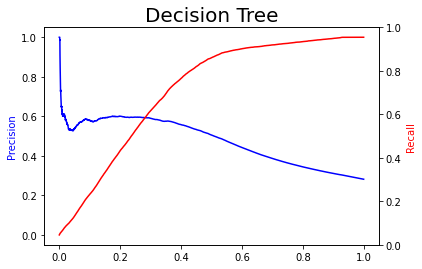

In [47]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, decision_precision_vals, "-b")
ax1.plot(x, decision_recall_vals, "-r")
ax1.set_title("Decision Tree")
ax1.title.set_size(20)
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
plt.show()

## xgboost

In [20]:
import xgboost as xgb

In [21]:
xgb_classifier = xgb.XGBClassifier(max_depth = 7, eta = 0.3, learning_rate = 1e-3)
xgb_classifier = xgb_classifier.fit(train_features, train_labels)

In [22]:
xgb_results = np.concatenate([xgb_classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
xgb_results = xgb_results[xgb_results[:, 1].argsort()]

In [23]:
n = 10000
x = np.linspace(1/n, 1, n)
xgb_precision_vals = [precision(xgb_results,x_i) for x_i in x]
xgb_recall_vals = [recall(xgb_results,x_i) for x_i in x]

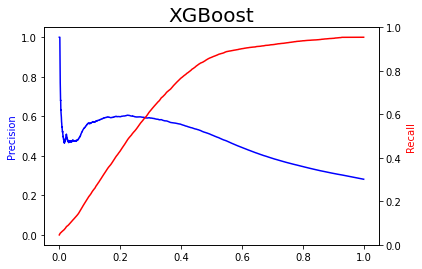

In [48]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, xgb_precision_vals, "-b")
ax1.plot(x, xgb_recall_vals, "-r")
ax1.set_title("XGBoost")
ax1.title.set_size(20)
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
plt.show()

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
randomf_classifier = RandomForestClassifier(n_estimators = 160, max_depth = 3)
randomf_classifier = randomf_classifier.fit(train_features, train_labels)

In [27]:
randomf_results = np.concatenate([randomf_classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
randomf_results = randomf_results[randomf_results[:, 1].argsort()]

In [28]:
n = 10000
x = np.linspace(1/n, 1, n)
randomf_precision_vals = [precision(randomf_results,x_i) for x_i in x]
randomf_recall_vals = [recall(randomf_results,x_i) for x_i in x]

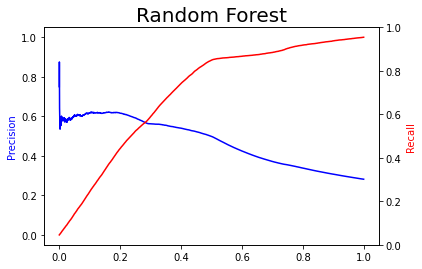

In [49]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, randomf_precision_vals, "-b")
ax1.plot(x, randomf_recall_vals, "-r")
ax1.set_title("Random Forest")
ax1.title.set_size(20)
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
plt.show()

## Neural Net

In [30]:
from sklearn.neural_network import MLPClassifier

In [31]:
nn_classifier = MLPClassifier(hidden_layer_sizes = [32]*3, activation = "relu", solver = "adam", learning_rate_init = 1e-4)
nn_classifier = nn_classifier.fit(train_features, train_labels)

In [32]:
nn_results = np.concatenate([nn_classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
nn_results = nn_results[nn_results[:, 1].argsort()]

In [33]:
n = 10000
x = np.linspace(1/n, 1, n)
nn_precision_vals = [precision(nn_results,x_i) for x_i in x]
nn_recall_vals = [recall(nn_results,x_i) for x_i in x]

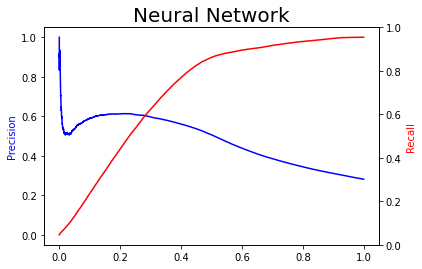

In [50]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, nn_precision_vals, "-b")
ax1.plot(x, nn_recall_vals, "-r")
ax1.set_title("Neural Network")
ax1.title.set_size(20)
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
plt.show()